# Testing Jacobian Regularization on MNIST using LeNet

### Imports and Data Loading

In [1]:
import torch
import jupyter_black
from torchsummary import summary

from data_generators import data_loader_MNIST
from model_classes import LeNet_MNIST
from tools import train, load_model
from plotting_tools import (
    plot_results,
    plot_reg_results,
    plot_activations_pca,
    plot_decision_boundary,
    plot_and_print_img,
    generate_random_vectors,
    get_random_img,
    plot_fgsm,
)

jupyter_black.load()

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Loading MNIST dataset
train_loader, test_loader = data_loader_MNIST()
summary_model = LeNet_MNIST(lr=0.1, momentum=0.9).to(device)
summary(summary_model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Dropout: 1-6                           [-1, 120]                 --
├─Linear: 1-7                            [-1, 84]                  10,164
├─Dropout: 1-8                           [-1, 84]                  --
├─Linear: 1-9                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─MaxPool2d: 1-2                         [-1, 6, 14, 14]           --
├─Conv2d: 1-3                            [-1, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 120]                 48,120
├─Dropout: 1-6                           [-1, 120]                 --
├─Linear: 1-7                            [-1, 84]                  10,164
├─Dropout: 1-8                           [-1, 84]                  --
├─Linear: 1-9                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29

In [4]:
# Hyperparameters
lr = 0.1
momentum = 0.9
l2_lmbd = 0.0005
jacobi_reg_lmbd = 0.01
svb_freq = 100
svb_eps = 0.01

### No regularization

#### Training

In [5]:
"""
model_no_reg = LeNet_MNIST(lr=lr, momentum=momentum).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model_no_reg, device, n_epochs
)"""

'\nmodel_no_reg = LeNet_MNIST(lr=lr, momentum=momentum).to(device)\nn_epochs = 5\nlosses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(\n    train_loader, test_loader, model_no_reg, device, n_epochs\n)'

#### Alternatively: Get Pretrained Model

In [6]:
(
    model_no_reg,
    losses,
    reg_losses,
    epochs,
    train_accuracies,
    test_accuracies,
) = load_model("model_no_reg")

#### Visualization

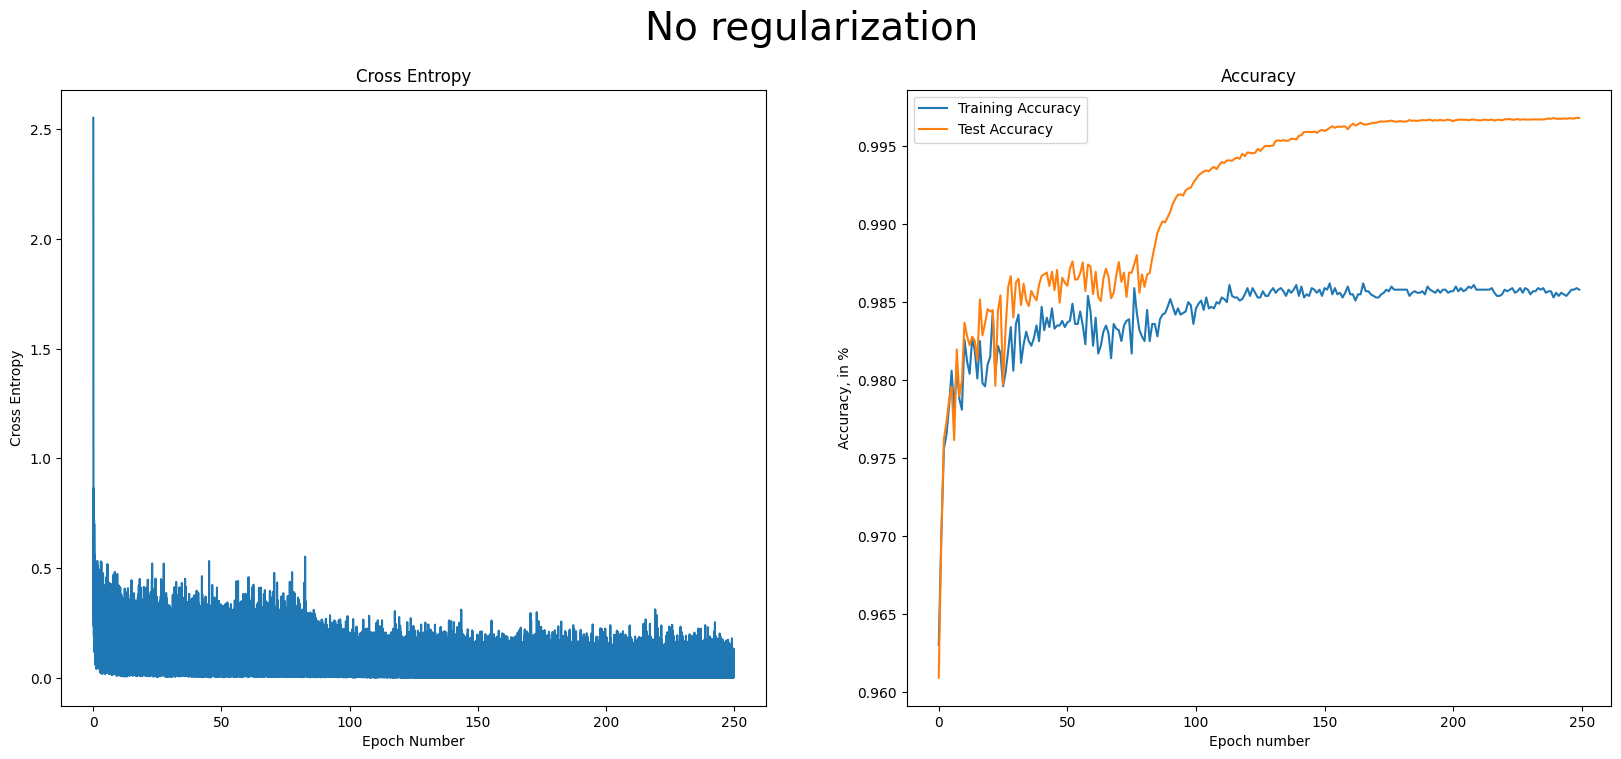

In [7]:
plot_results(
    epochs, losses, train_accuracies, test_accuracies, title="No regularization"
)

In [8]:
# plot_activations_pca(model_no_reg, train_loader, device)

Prediction with no regularization: 1


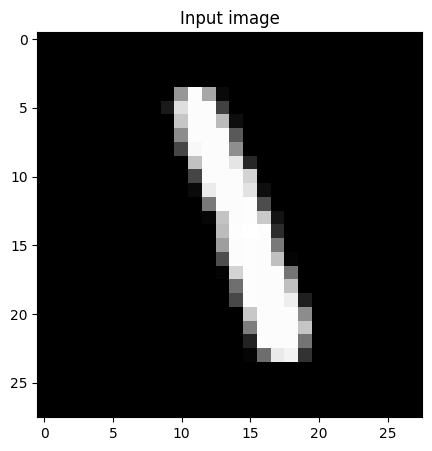

c:\Users\aslak\.conda\envs\jacreg\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


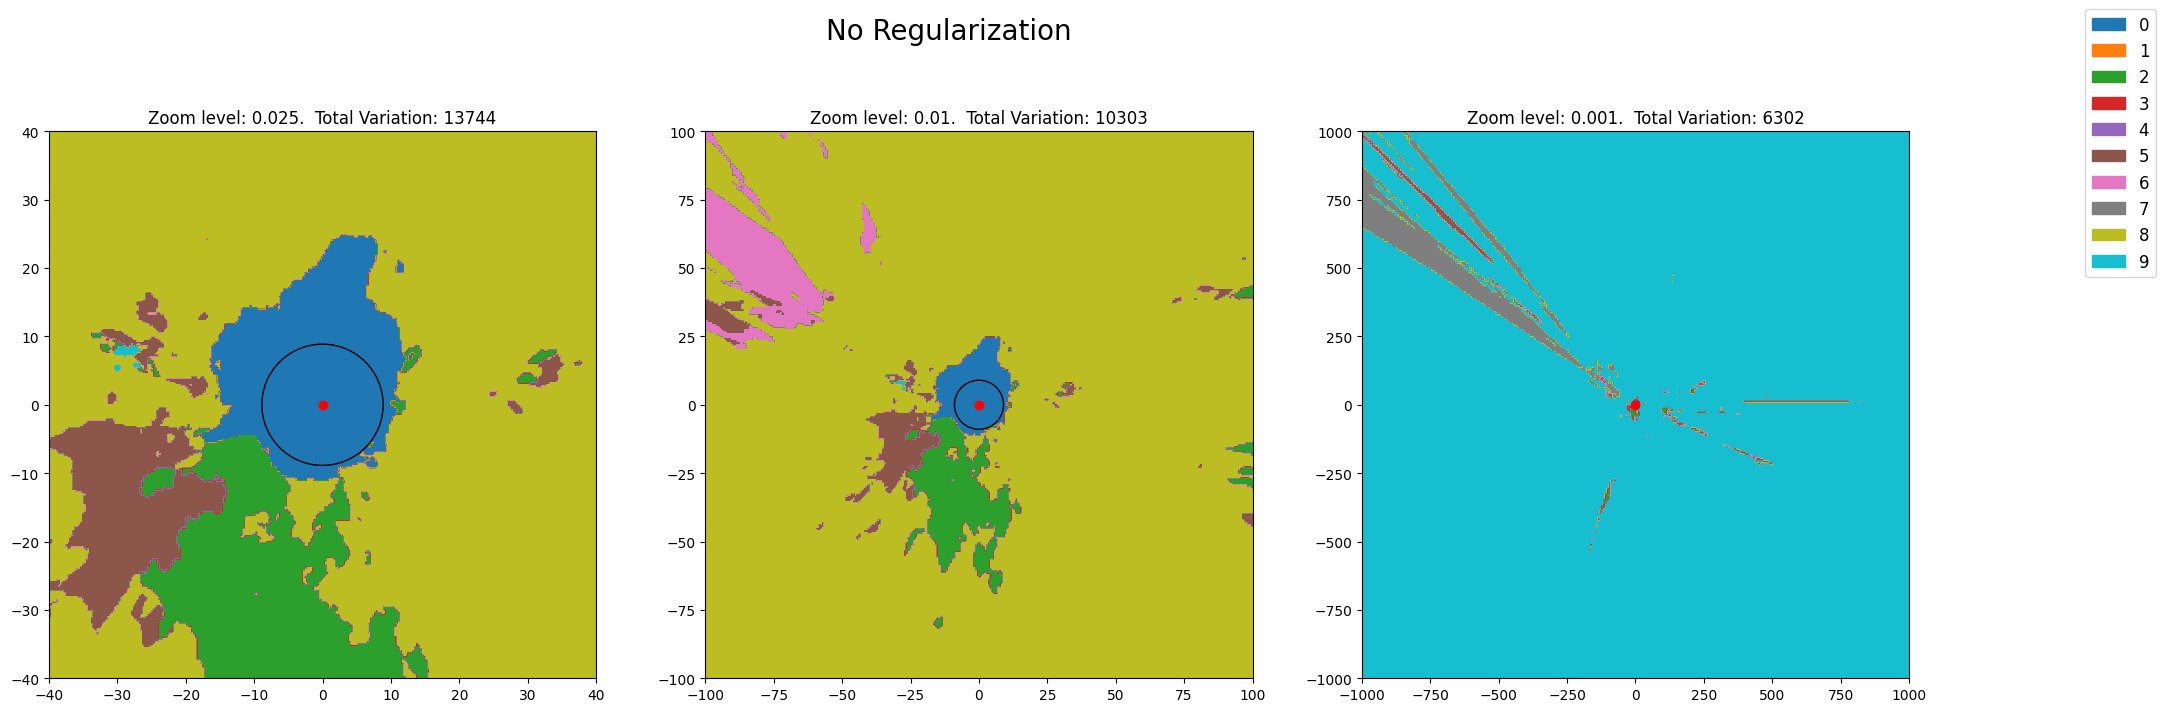

In [9]:
image = get_random_img(test_loader)
v1, v2 = generate_random_vectors(image)
plot_and_print_img(image, model_no_reg, device, "no regularization")
plot_decision_boundary(model_no_reg, image, v1, v2, device, title="No Regularization")

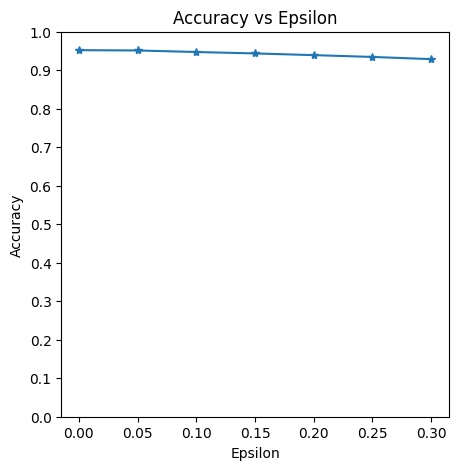

In [10]:
plot_fgsm(model_no_reg, device, test_loader)

### L2 Regularization

#### Training

In [11]:
"""model_l2 = LeNet_MNIST(lr=lr, momentum=momentum, l2_lmbd=l2_lmbd).to(device)
n_epochs = 1
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model_l2, device, n_epochs
)"""

'model_l2 = LeNet_MNIST(lr=lr, momentum=momentum, l2_lmbd=l2_lmbd).to(device)\nn_epochs = 1\nlosses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(\n    train_loader, test_loader, model_l2, device, n_epochs\n)'

#### Alternatively: Get Pretrained Model

In [12]:
(
    model_l2,
    losses,
    reg_losses,
    epochs,
    train_accuracies,
    test_accuracies,
) = load_model("model_l2")

#### Visualization

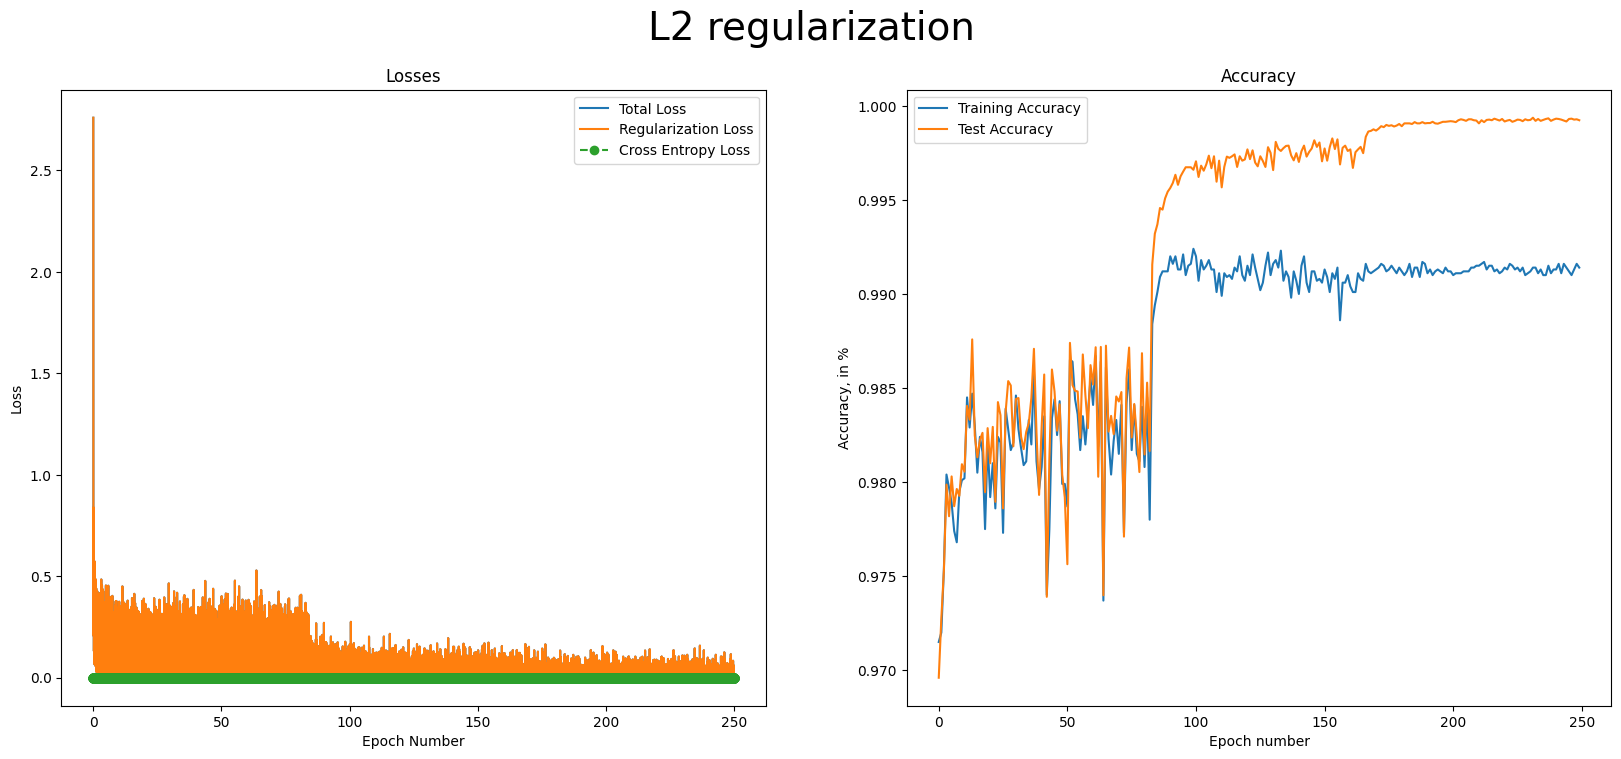

In [13]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="L2 regularization",
)

In [14]:
# plot_activations_pca(model_l2, train_loader, device)

Prediction with L2 regularization: 1


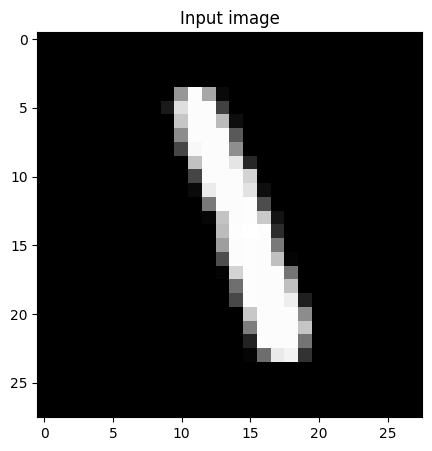

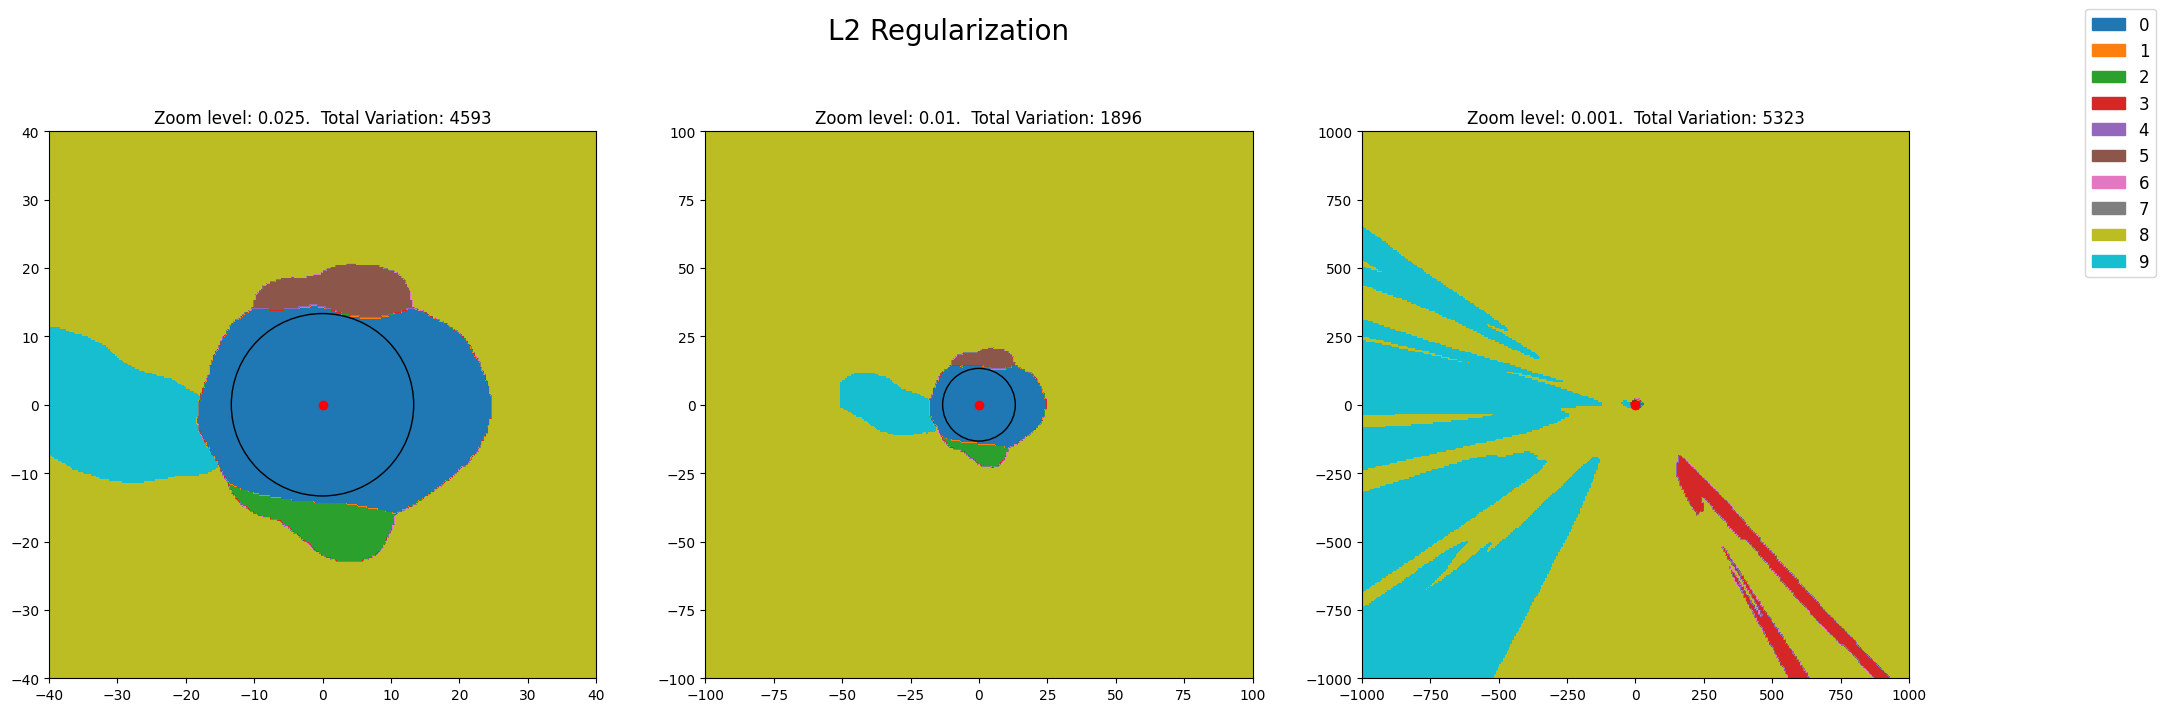

In [15]:
image = get_random_img(test_loader)
v1, v2 = generate_random_vectors(image)
plot_and_print_img(image, model_l2, device, "L2 regularization")
plot_decision_boundary(model_l2, image, v1, v2, device, title="L2 Regularization")

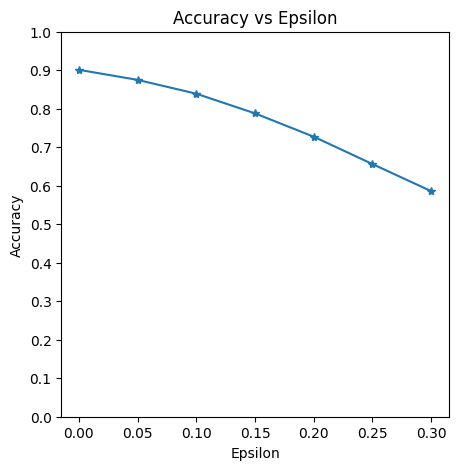

In [16]:
plot_fgsm(model_l2, device, test_loader)

### Jacobi Regularization

#### Training

In [17]:
"""model_jacobi = LeNet_MNIST(
    lr=lr,
    momentum=momentum,
    jacobi_reg=True,
    jacobi_reg_lmbd=jacobi_reg_lmbd,
).to(device)
n_epochs = 5  # Paper: 250 epochs
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model_jacobi, device, n_epochs
)"""

'model_jacobi = LeNet_MNIST(\n    lr=lr,\n    momentum=momentum,\n    jacobi_reg=True,\n    jacobi_reg_lmbd=jacobi_reg_lmbd,\n).to(device)\nn_epochs = 5  # Paper: 250 epochs\nlosses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(\n    train_loader, test_loader, model_jacobi, device, n_epochs\n)'

#### Alternatively: Get Pretrained Model

In [18]:
(
    model_jacobi,
    losses,
    reg_losses,
    epochs,
    train_accuracies,
    test_accuracies,
) = load_model("model_jacobi")

#### Visualization

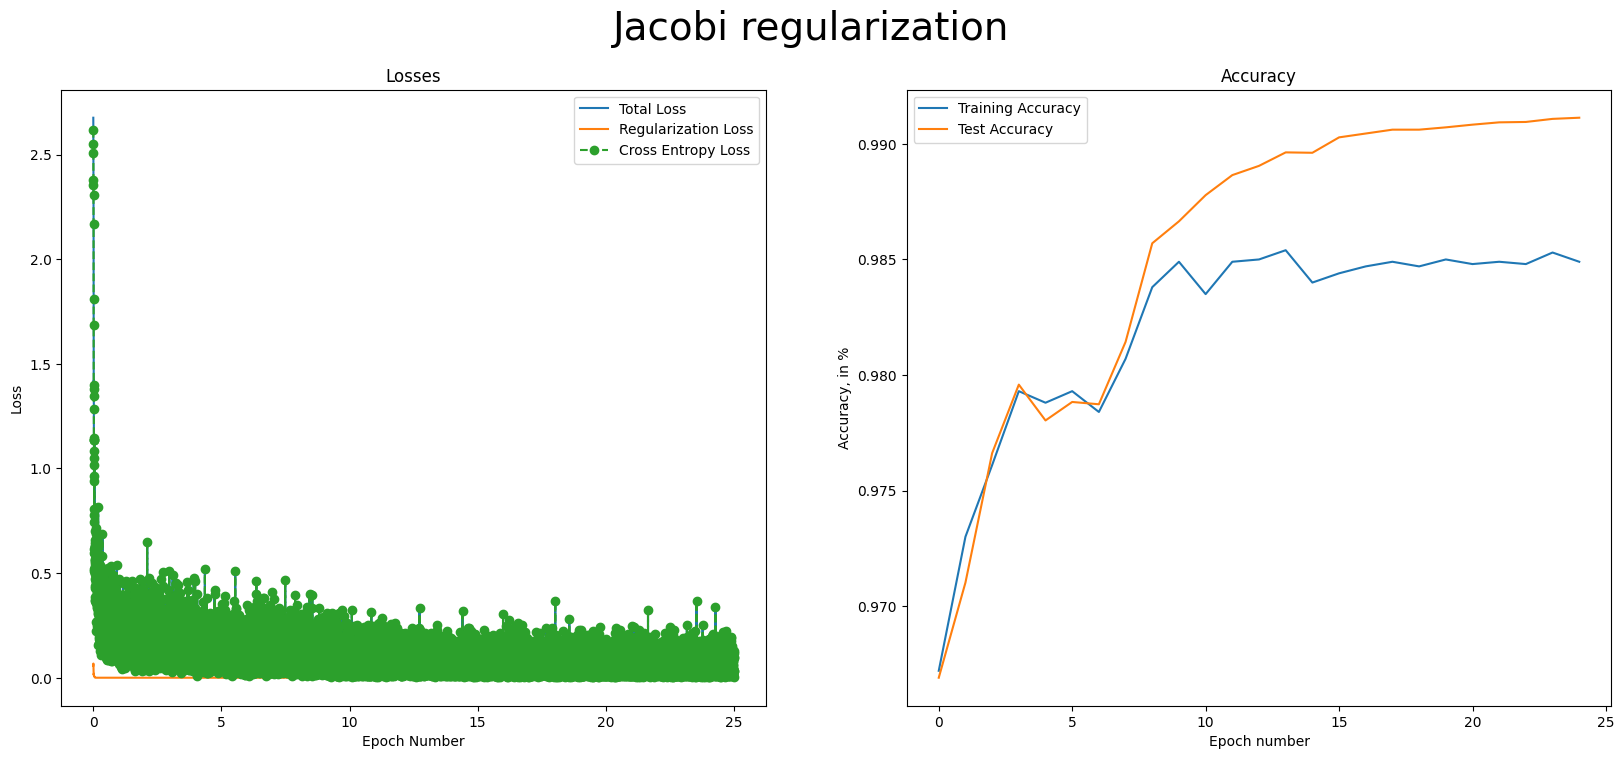

In [19]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="Jacobi regularization",
)

In [20]:
# plot_activations_pca(model_jacobi, train_loader, device)

Prediction with Jacobi regularization: 6


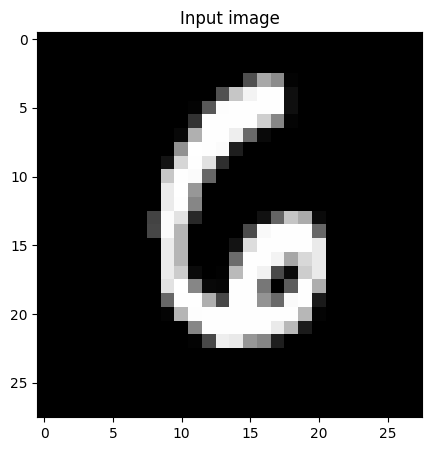

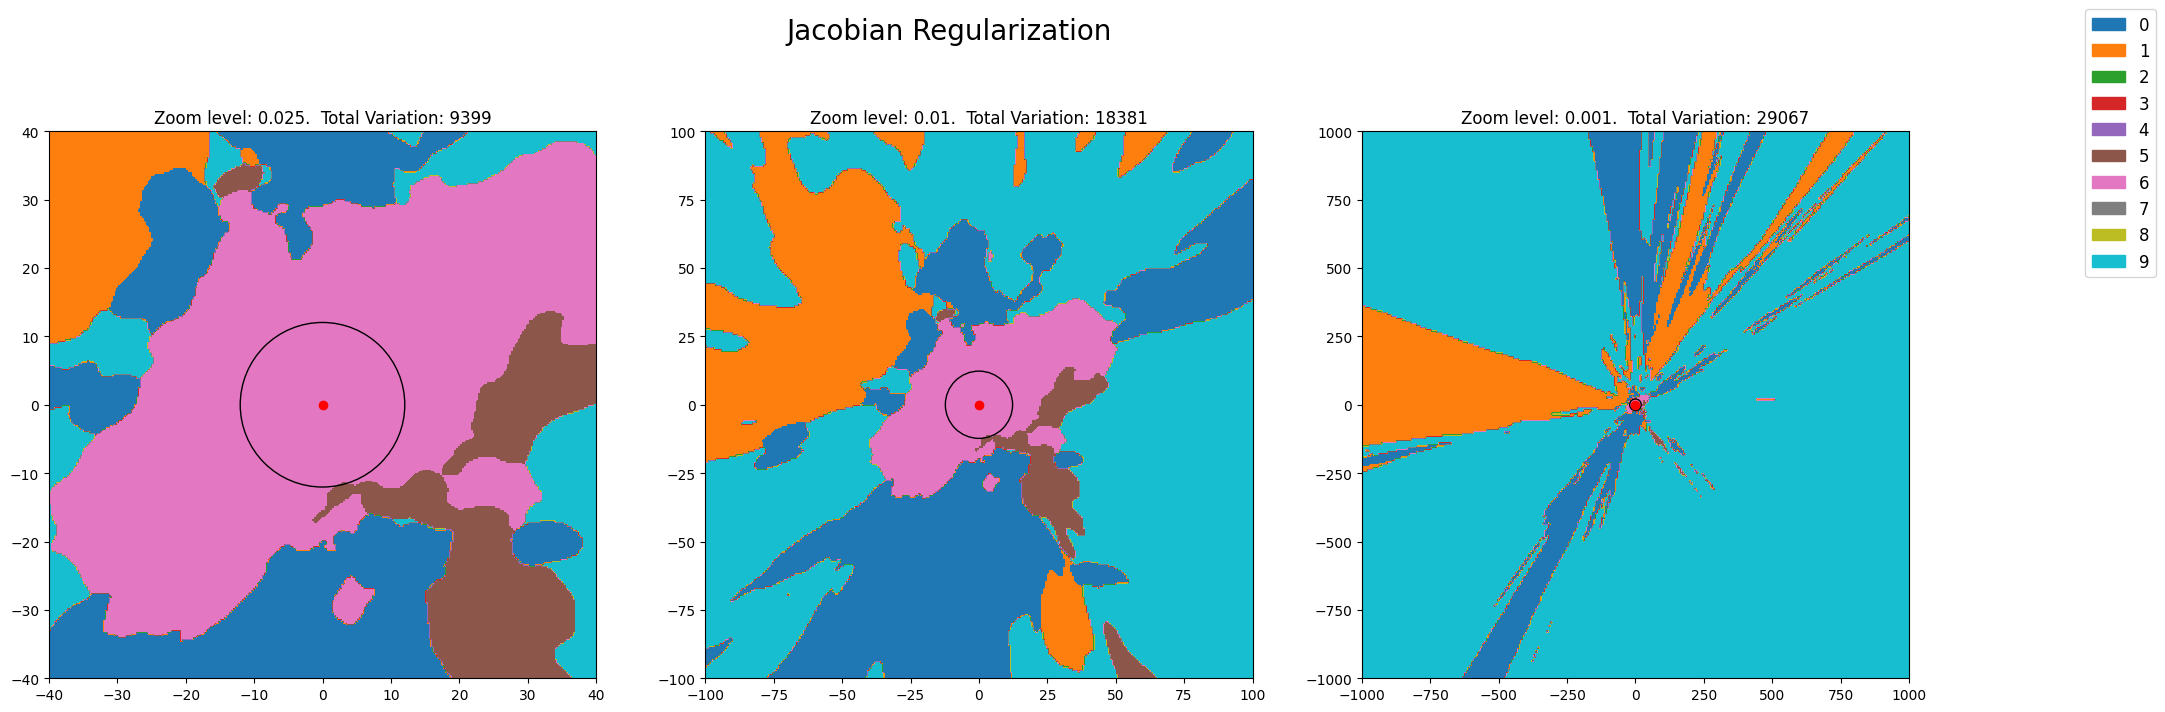

In [21]:
image = get_random_img(test_loader)
v1, v2 = generate_random_vectors(image)
plot_and_print_img(image, model_jacobi, device, "Jacobi regularization")
plot_decision_boundary(
    model_jacobi, image, v1, v2, device, title="Jacobian Regularization"
)

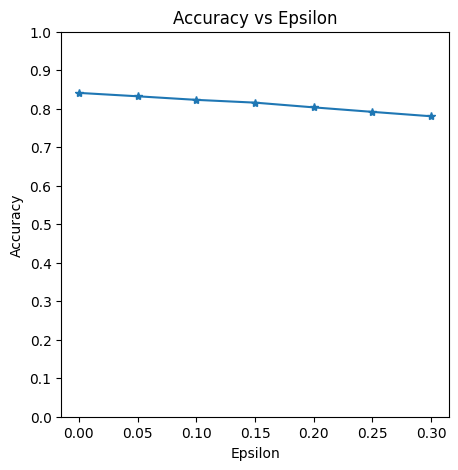

In [22]:
plot_fgsm(model_jacobi, device, test_loader)

### SVB Regularization

#### Training

In [23]:
"""model_svb = LeNet_MNIST(
    lr=lr,
    momentum=momentum,
    svb_reg=True,
    svb_freq=svb_freq,
    svb_eps=svb_eps,
).to(device)
n_epochs = 5  # Paper: 250 epochs
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model_svb, device, n_epochs
)"""

'model_svb = LeNet_MNIST(\n    lr=lr,\n    momentum=momentum,\n    svb_reg=True,\n    svb_freq=svb_freq,\n    svb_eps=svb_eps,\n).to(device)\nn_epochs = 5  # Paper: 250 epochs\nlosses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(\n    train_loader, test_loader, model_svb, device, n_epochs\n)'

#### Alternatively: Get Pretrained Model

In [24]:
(
    model_svb,
    losses,
    reg_losses,
    epochs,
    train_accuracies,
    test_accuracies,
) = load_model("model_svb")

#### Visualization

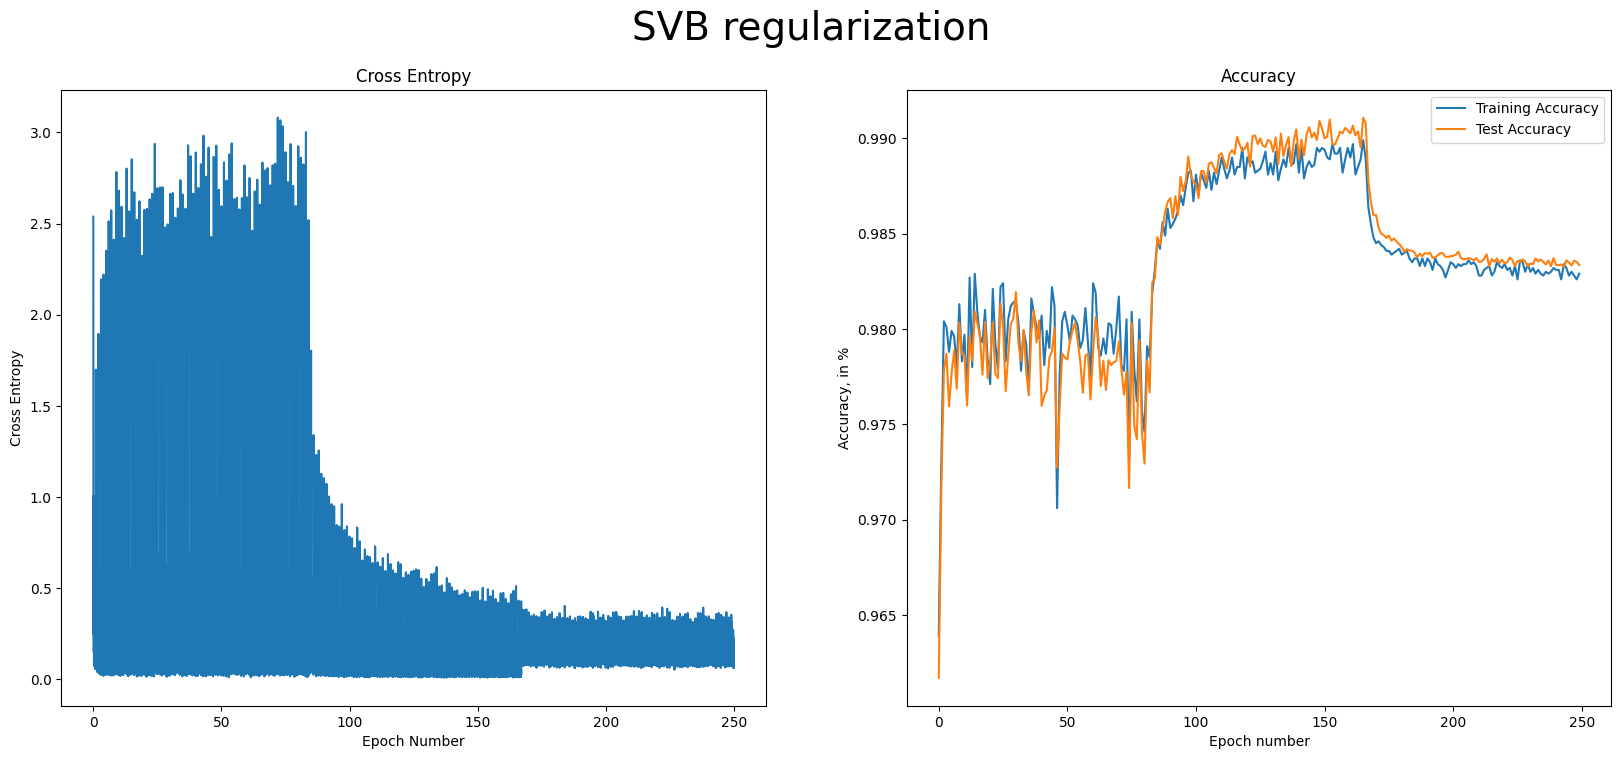

In [25]:
plot_results(
    epochs,
    losses,
    train_accuracies,
    test_accuracies,
    title="SVB regularization",
)

In [26]:
# plot_activations_pca(model_svb, train_loader, device)

Prediction with SVB regularization: 9


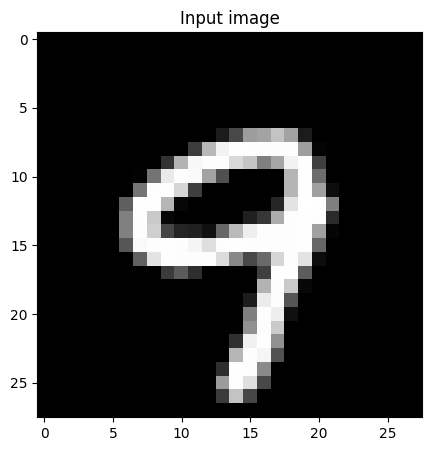

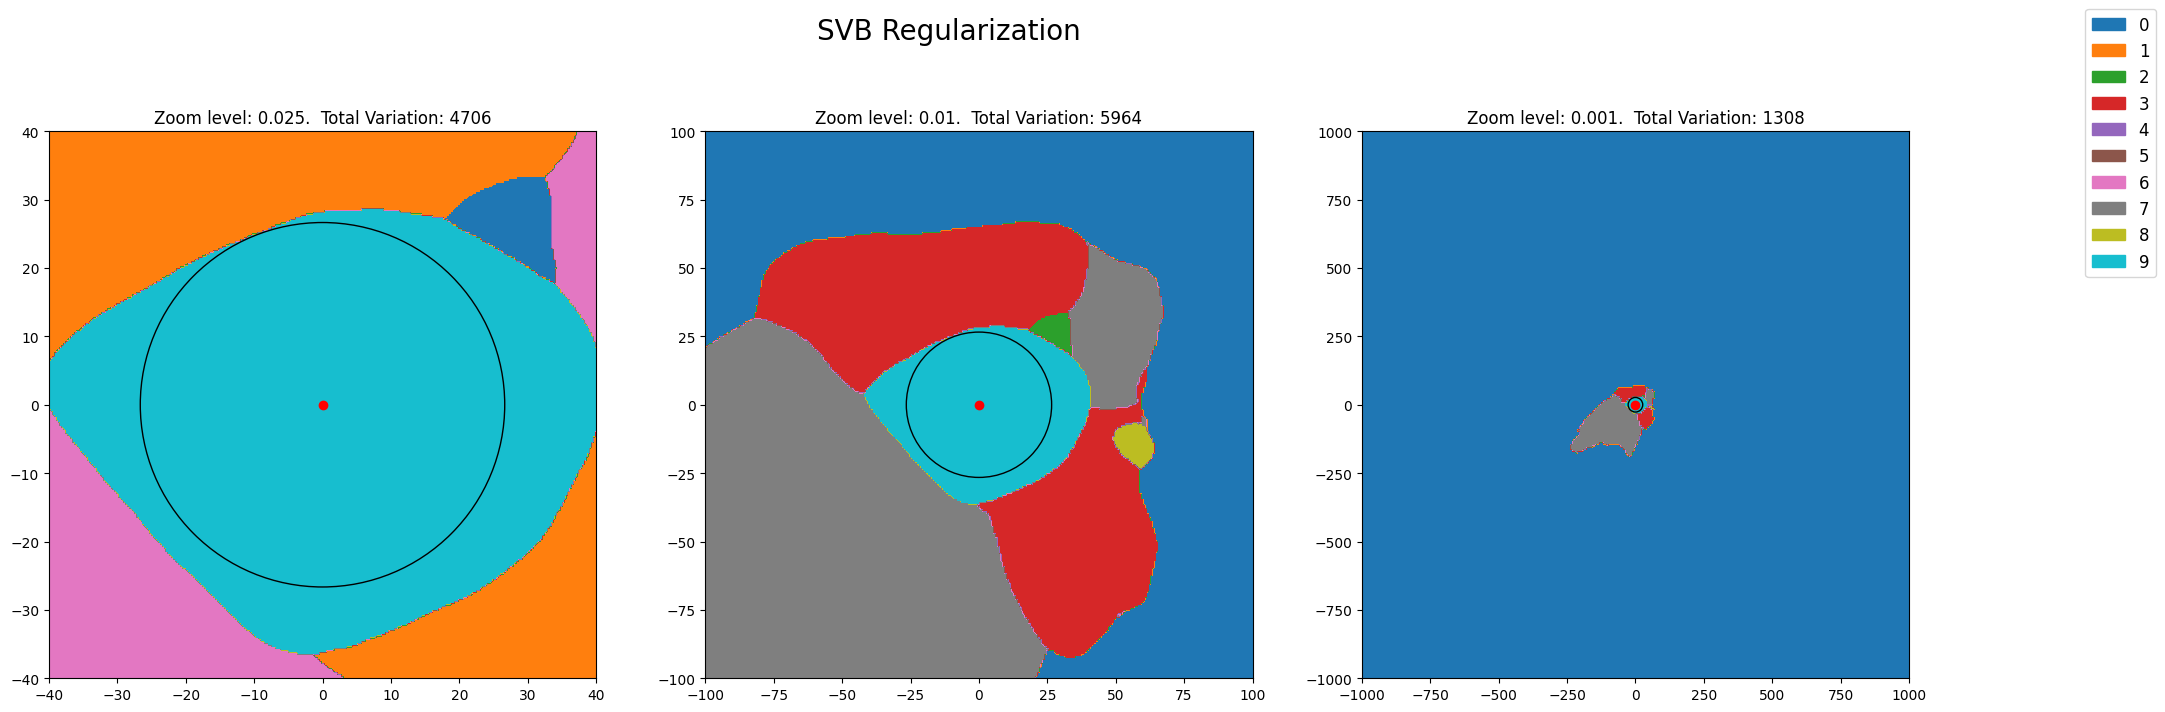

In [27]:
image = get_random_img(test_loader)
v1, v2 = generate_random_vectors(image)
plot_and_print_img(image, model_svb, device, "SVB regularization")
plot_decision_boundary(model_svb, image, v1, v2, device, title="SVB Regularization")

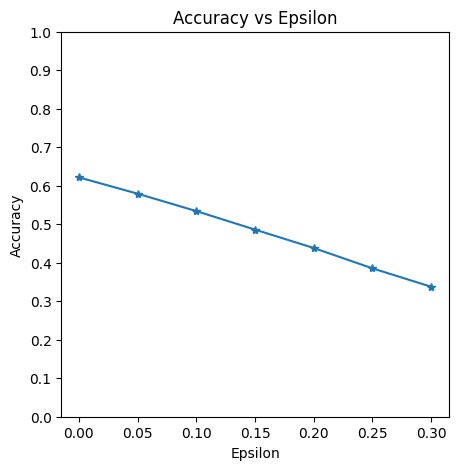

In [28]:
plot_fgsm(model_svb, device, test_loader)

### Comparison Between Models

Prediction with Jacobi regularization: 7


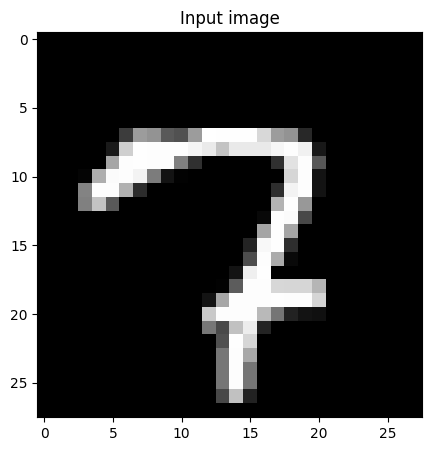

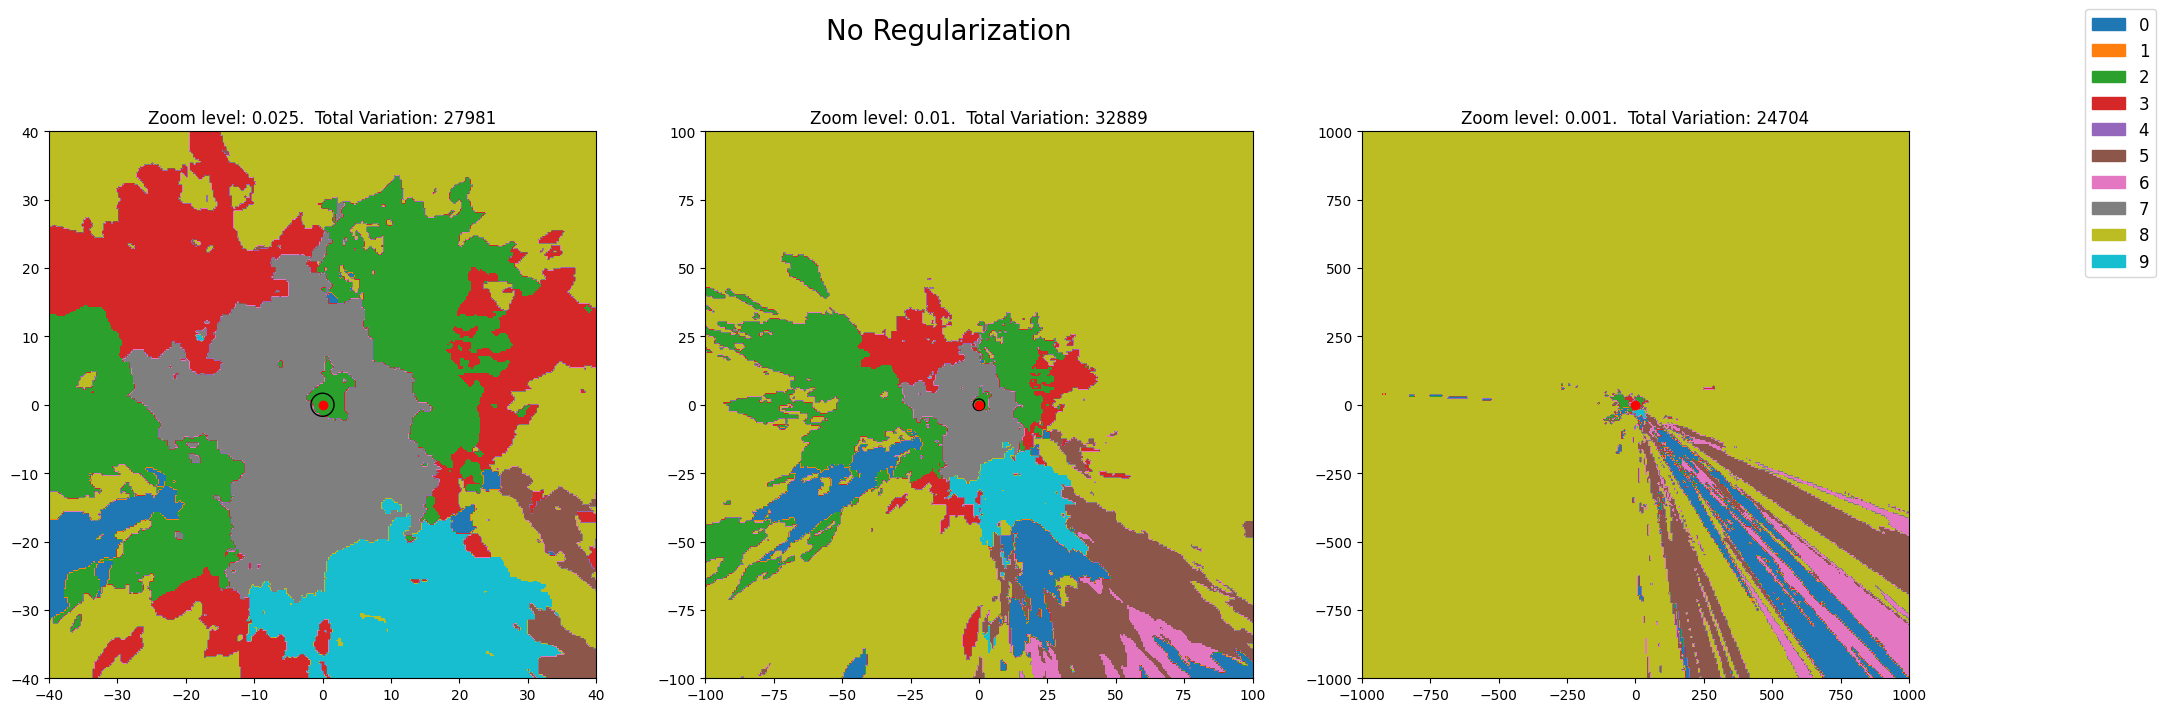

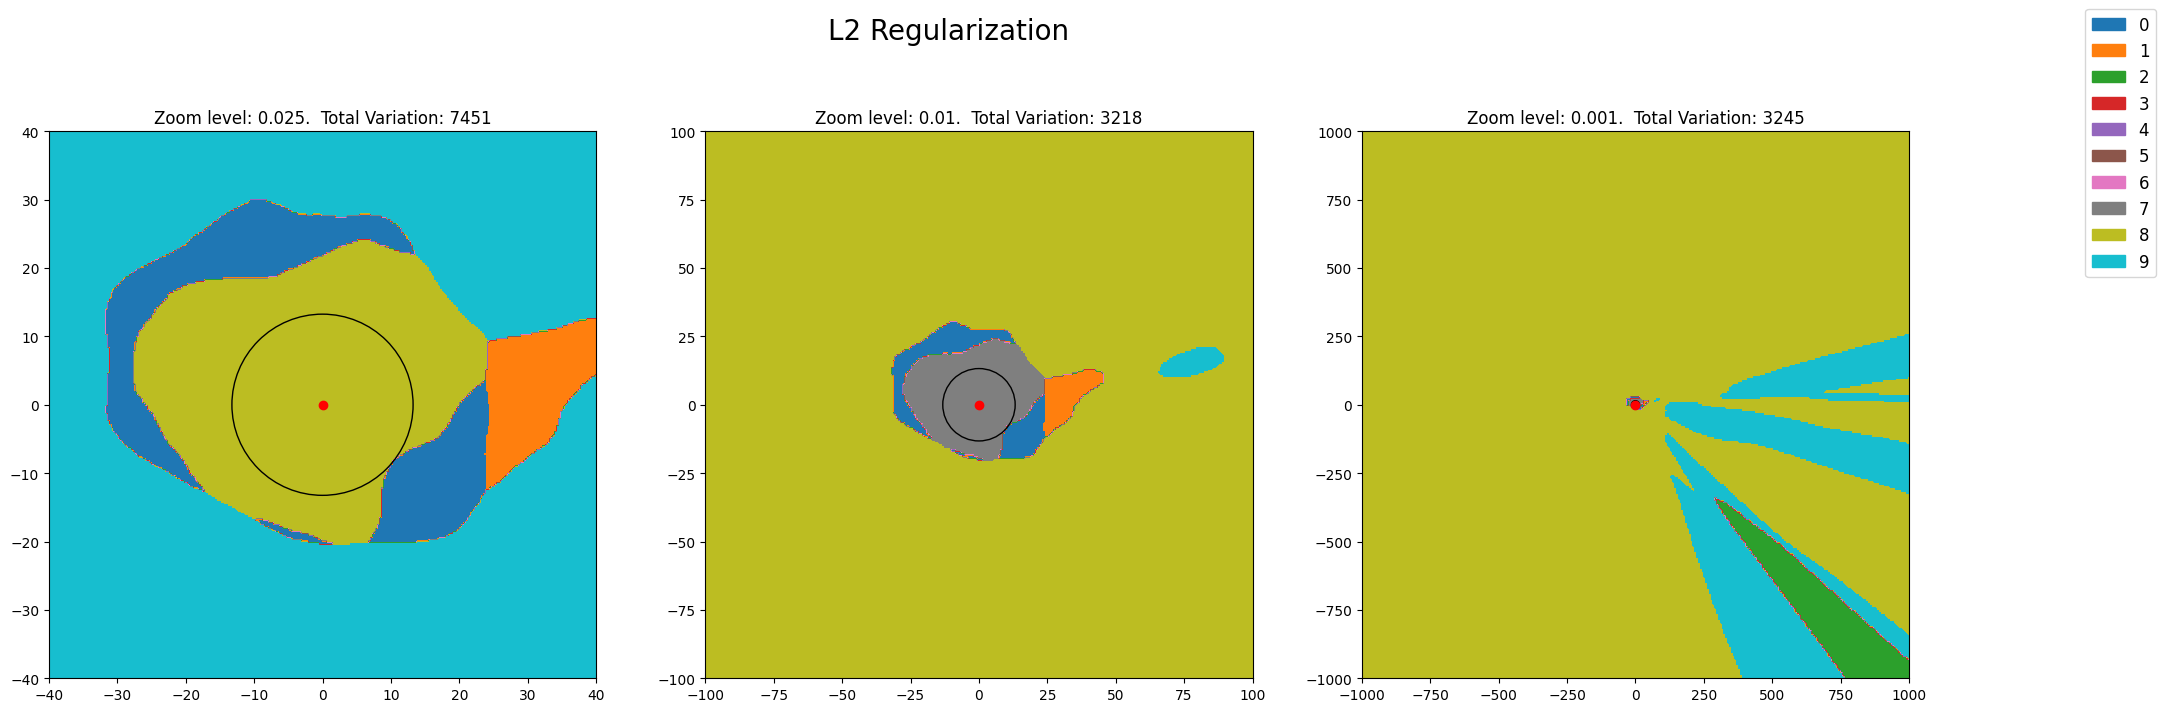

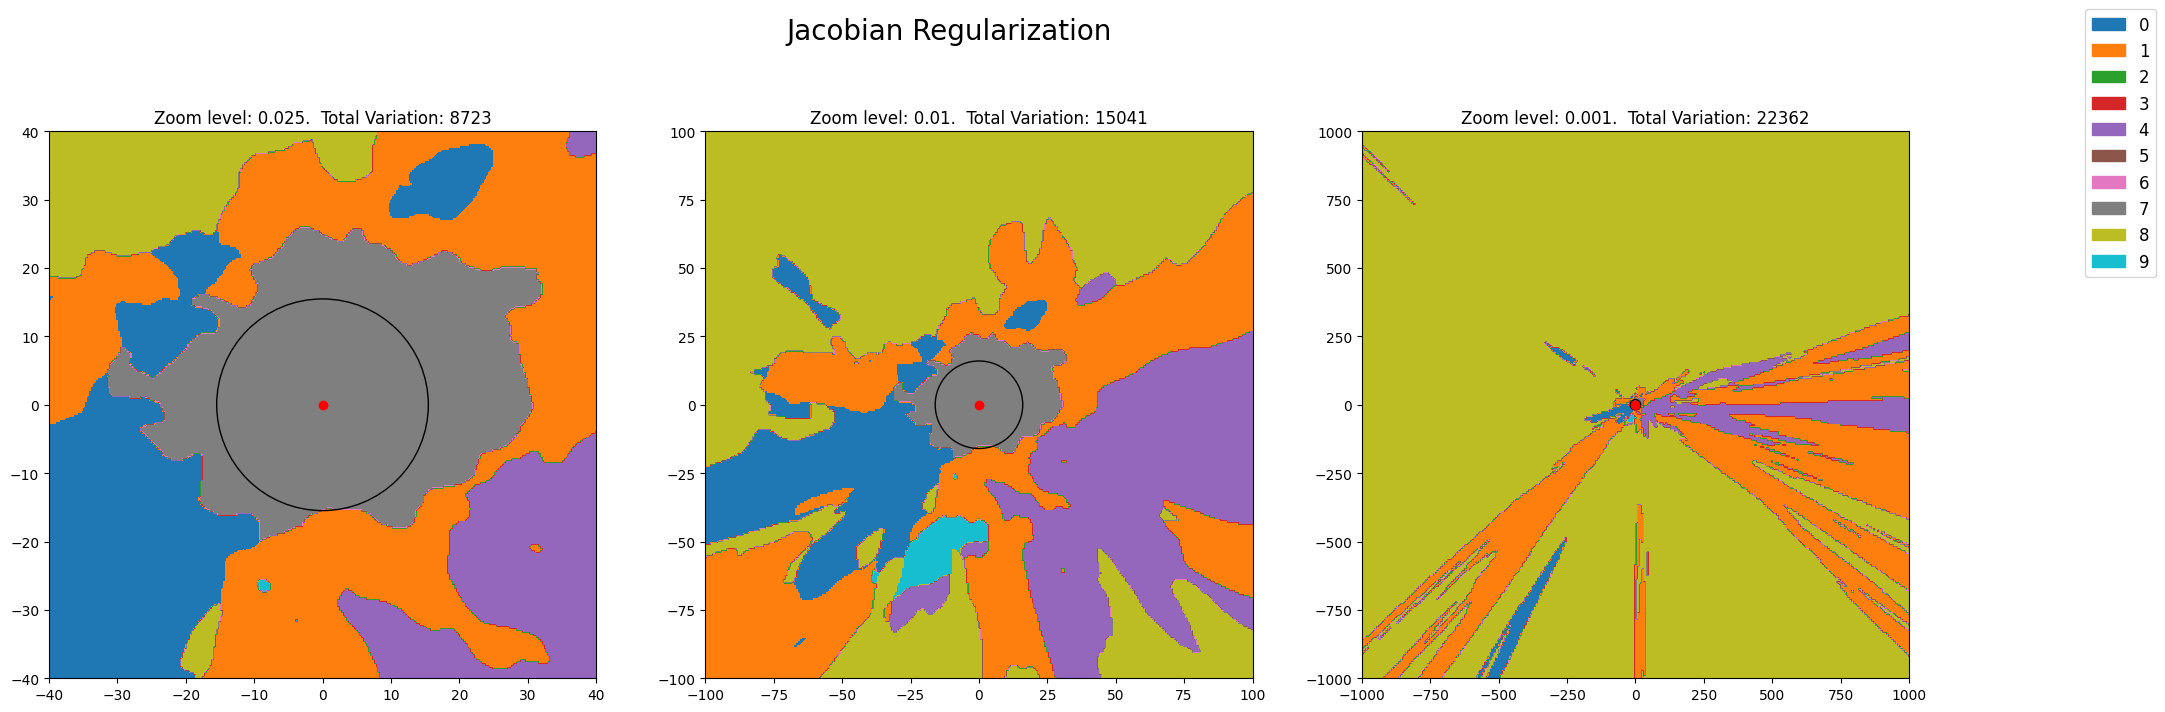

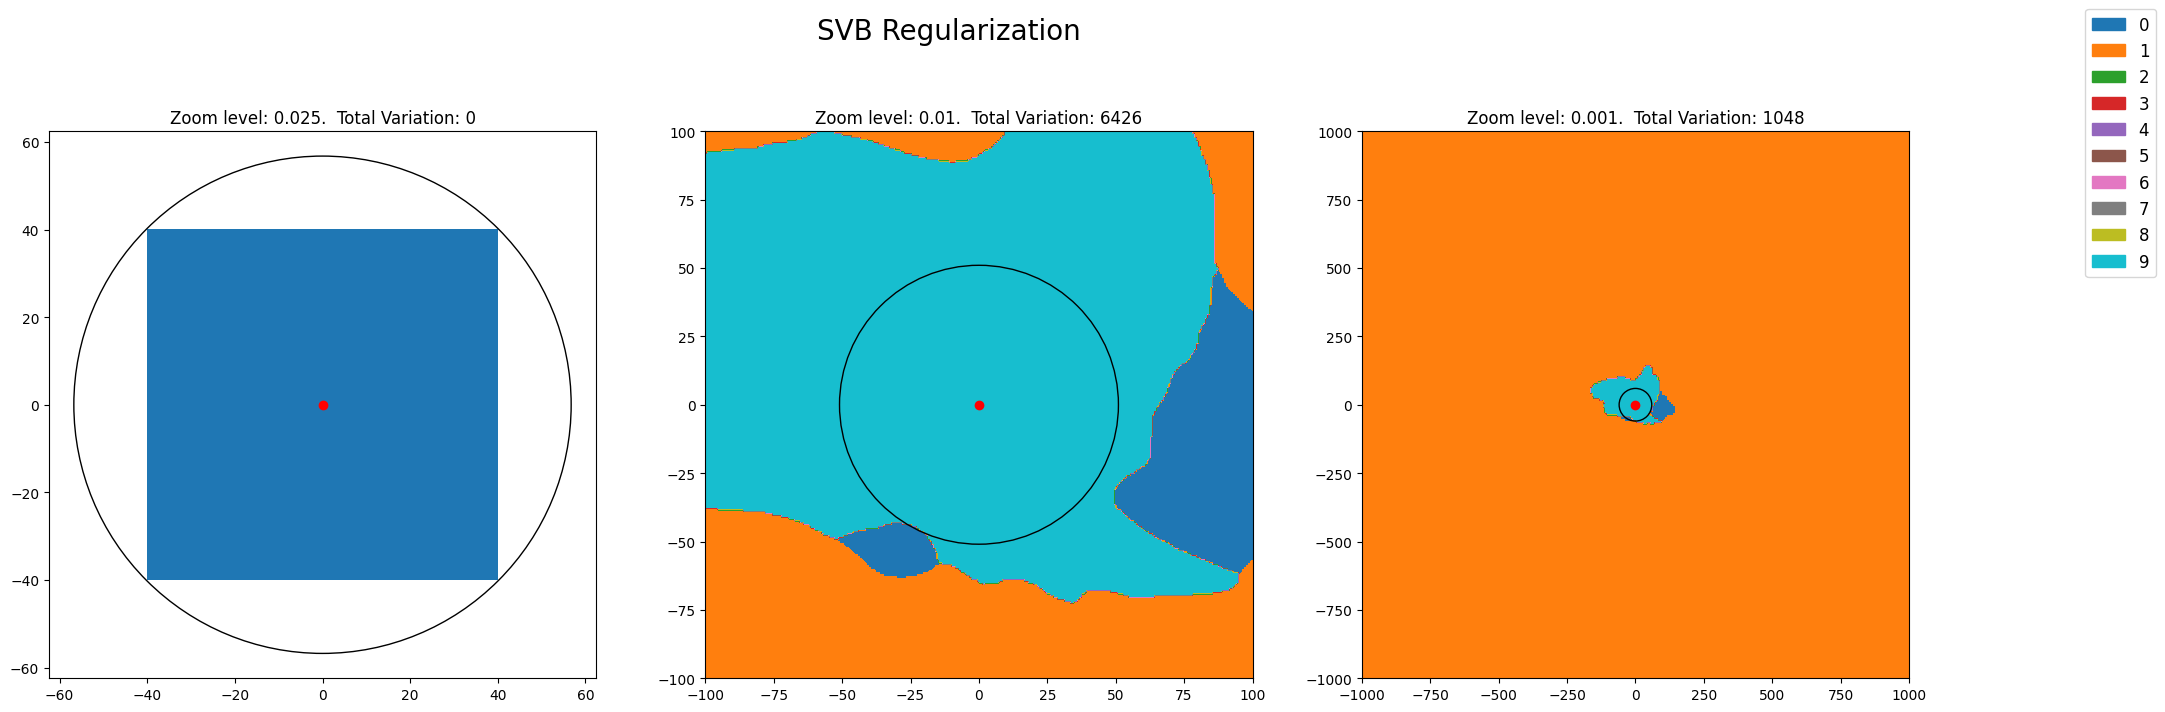

In [29]:
image = get_random_img(test_loader)
v1, v2 = generate_random_vectors(image)
plot_and_print_img(image, model_jacobi, device, "Jacobi regularization")
plot_decision_boundary(model_no_reg, image, v1, v2, device, title="No Regularization")
plot_decision_boundary(model_l2, image, v1, v2, device, title="L2 Regularization")
plot_decision_boundary(
    model_jacobi, image, v1, v2, device, title="Jacobian Regularization"
)
plot_decision_boundary(model_svb, image, v1, v2, device, title="SVB Regularization")